### **COVID-19**

***Second version***

**Objective** : using univariate LSTM to predict the number of coronavirus cases in Colombia the following day  with the determination that the health system is the demand that will open.


In [0]:
#Importing package
#!pip install tensorflow==1.14.0

In [0]:
#Importing libraries
import pandas as pd
import numpy as np
from pandas import datetime
import matplotlib.pyplot as plt
import os
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import LabelEncoder  
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import math
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM




* **Data exploration**





In [3]:
#API connection
#!pip install requests
import requests
request = requests.get('https://www.datos.gov.co/resource/gt2j-8ykr.json')
print(request.status_code)

200


In [0]:
#200 means everything  is OK! 
request_json  = request.json()

In [5]:
#Normalize the data
from pandas.io.json import json_normalize
df= pd.DataFrame.from_dict(json_normalize(request_json), orient='columns')
df.head(3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


,id_de_caso,fecha_de_diagn_stico,ciudad_de_ubicaci_n,departamento,atenci_n,edad,sexo,tipo,pa_s_de_procedencia
0,1,06/03/2020,Bogotá,Bogotá D.C.,Recuperado,19,F,Importado,Italia
1,2,09/03/2020,Buga,Valle del Cauca,Recuperado,34,M,Importado,España
2,3,09/03/2020,Medellín,Antioquia,Recuperado,50,F,Importado,España


In [6]:
print("Dimension of the dataframe is:",len(df))
df.columns

Dimension of the dataframe is: 1000


Index(['id_de_caso', 'fecha_de_diagn_stico', 'ciudad_de_ubicaci_n',
       'departamento', 'atenci_n', 'edad', 'sexo', 'tipo',
       'pa_s_de_procedencia'],
      dtype='object')

In [7]:
#Renaming the variables
df.columns = ['casos','fecha', 'ciudad_ubicacion', 'dpto','atencion', 'edad', 'sexo', 'tipo','pais_procedencia']
df.head(3)

,casos,fecha,ciudad_ubicacion,dpto,atencion,edad,sexo,tipo,pais_procedencia
0,1,06/03/2020,Bogotá,Bogotá D.C.,Recuperado,19,F,Importado,Italia
1,2,09/03/2020,Buga,Valle del Cauca,Recuperado,34,M,Importado,España
2,3,09/03/2020,Medellín,Antioquia,Recuperado,50,F,Importado,España




*  **Data preparation**




In [8]:
#Set the index time
df.fecha=pd.to_datetime(df.fecha, format='%d/%m/%Y') 
df.set_index('fecha',inplace=True)
df.head(3) 

,casos,ciudad_ubicacion,dpto,atencion,edad,sexo,tipo,pais_procedencia
fecha,,,,,,,,
2020-03-06,1,Bogotá,Bogotá D.C.,Recuperado,19,F,Importado,Italia
2020-03-09,2,Buga,Valle del Cauca,Recuperado,34,M,Importado,España
2020-03-09,3,Medellín,Antioquia,Recuperado,50,F,Importado,España


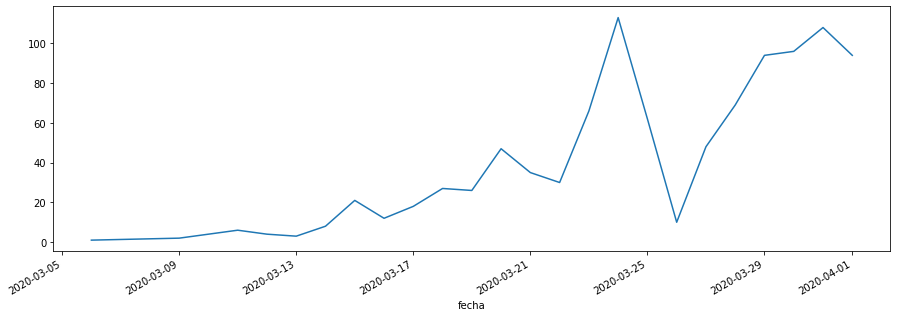

In [9]:
#Tranforming data into time series
ts = df.groupby("fecha")["casos"].count()
ts.plot(figsize=(15,5))
data = pd.DataFrame(ts)

In [10]:
data.describe()

,casos
count,24.000000
mean,41.666667
std,37.181887
min,1.000000
25%,9.500000
50%,28.500000
75%,66.750000
max,113.000000


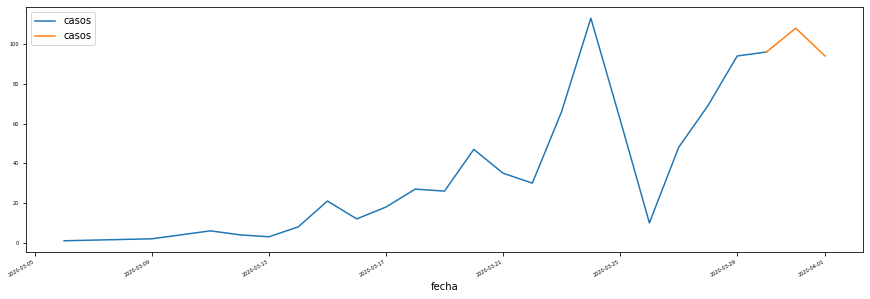

In [27]:
#split the data(90%-10%)just for plotting
test_period =int(round(len(data)*0.9,0))   
train = data.iloc[:test_period,]
test = data.iloc[test_period-1:,]
ax=train.plot(figsize=(15,8), fontsize=10)
test.plot(ax=ax,figsize=(15,5), fontsize=5)
plt.show()

In [0]:
# Split a univariate sequence into samples
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1
    dat = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dat.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dat.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [13]:
data_samples = series_to_supervised(train,3,1)
data_samples.tail(3)

,var1(t-3),var1(t-2),var1(t-1),var1(t)
fecha,,,,
2020-03-28,62.0,10.0,48.0,69
2020-03-29,10.0,48.0,69.0,94
2020-03-30,48.0,69.0,94.0,96


**Normalization data**

In [14]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_norm = scaler.fit_transform(data_samples)
data_norm

array([[0.        , 0.        , 0.02727273, 0.00909091],
       [0.00892857, 0.03603604, 0.00909091, 0.        ],
       [0.04464286, 0.01801802, 0.        , 0.04545455],
       [0.02678571, 0.00900901, 0.04545455, 0.16363636],
       [0.01785714, 0.05405405, 0.16363636, 0.08181818],
       [0.0625    , 0.17117117, 0.08181818, 0.13636364],
       [0.17857143, 0.09009009, 0.13636364, 0.21818182],
       [0.09821429, 0.14414414, 0.21818182, 0.20909091],
       [0.15178571, 0.22522523, 0.20909091, 0.4       ],
       [0.23214286, 0.21621622, 0.4       , 0.29090909],
       [0.22321429, 0.40540541, 0.29090909, 0.24545455],
       [0.41071429, 0.2972973 , 0.24545455, 0.57272727],
       [0.30357143, 0.25225225, 0.57272727, 1.        ],
       [0.25892857, 0.57657658, 1.        , 0.53636364],
       [0.58035714, 1.        , 0.53636364, 0.06363636],
       [1.        , 0.54054054, 0.06363636, 0.40909091],
       [0.54464286, 0.07207207, 0.40909091, 0.6       ],
       [0.08035714, 0.41441441,

In [0]:
#Now split the data 90%-10%
train_data_norm = data_norm[:int(round(len(data_norm)*0.9,0)), :]
test_data_norm = data_norm[int(round(len(data_norm)*0.9,0)):len(data_norm), :]

In [0]:
#split the train and test set into X,Y
train_x, train_y = train_data_norm[:, :-1], train_data_norm[:, -1]
test_x, test_y = test_data_norm[:, :-1], test_data_norm[:, -1]


In [17]:
#reshape input to be 3D [samples, timesteps, features]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(17, 1, 3) (17,) (2, 1, 3) (2,)


**Modeling**






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 17 samples, validate on 2 samples
Epoch 1/60
17/17 [==============================] - 1s 35ms/step - loss: 0.1625 - val_loss: 0.7284
Epoch 2/60
17/17 [==============================] - 0s 407us/step - loss: 0.1602 - val_loss: 0.7200
Epoch 3/60
17/17 [==============================] - 0s 399us/step - loss: 0.1575 - val_loss: 0.7110
Epoch 4/60
17/17 [==============================] - 0s 370us/step - loss: 0.1548 - val_loss: 0.7019
Epoch 5/60
17/17 [==============================] - 0s 356us/step - loss: 0.1519 - val_loss: 0.6925
Epoch 6/60
17/17 [==============================] - 0s 220us/step - loss: 0.1491 - val_loss: 0.6830
Epoch 7/60
17/17 [==============================] - 0s 338us/step - loss: 0.1463 - val_loss: 0.6733
Epoch 8/60
17/17 [==============================] - 0s 334us/step - loss: 0.1434 - val_loss: 0.6637
Epoch 9/60
17/17 [==============================] - 0s 304

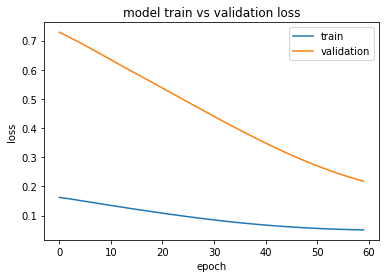

In [18]:
# design network
model = Sequential()
model.add(LSTM(100, activation='relu',input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# fit network
history = model.fit(train_x, train_y, epochs=60, validation_data=(test_x, test_y), shuffle=False)
# plot history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

We have increased the number of epoch and the total number of nodes and the underftting remains.

Therefore, the model is underfit because performance on the training set is better than the validation set and performance has leveled off. So, we need more samples to fit this model.

In [19]:
# make a prediction
yhat = model.predict(test_x)
test_x_r = test_x.reshape((test_x.shape[0],3))

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_x_r[:, :]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,3]
inv_yhat


array([69., 94.])

In [20]:
# invert scaling for actual
test_y_r = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y_r, test_x_r[:,:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,3]
inv_y

array([69., 94.])

In [21]:
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.000


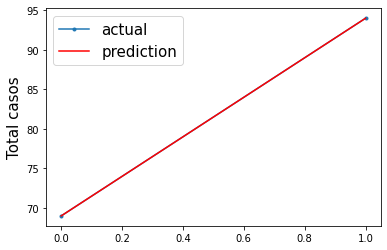

In [22]:
#plotting forecast vs real
aa=[x for x in range(2)]
plt.plot(aa, inv_y[:2], marker='.', label="actual")
plt.plot(aa, inv_yhat[:2], 'r', label="prediction")
plt.ylabel('Total casos', size=15)
plt.xlabel('', size=15)
plt.legend(fontsize=15)
plt.show()

In [0]:
from datetime import datetime
from datetime import timedelta
last=pd.DataFrame(data.index)
last=last.tail(1)
NextDay_Date = last + timedelta(days=1)
print(NextDay_Date.to_string(index=False))

In [32]:
#Prediction
x_input = np.array(data.tail(3))
x_input_norm = scaler.fit_transform(x_input)
x_input_norm = x_input_norm.reshape((1, 1, 3))
prediction_norm= model.predict(x_input_norm, verbose=0)
prediction = int(scaler.inverse_transform(prediction_norm))
print("Predicción del total de casos contagiados:",prediction,"para la",NextDay_Date.to_string(index=False))

Predicción del total de casos contagiados: 97 para la      fecha
2020-04-02
